# Análisis del sentimiento

Análisis del sentimiento se refiere a la tarea de clasificación de documentos en función de la connotación **positiva** o **negativa** del lenguaje.

En este ejercicio vamos a construir una red neuronal que entrenaremos con comentarios de crítica en español. El corpus se creó a partir del sitio de crítica gastronómica online Guía Oleo donde las opiniones de los usuarios sobre restaurantes se etiquetaron como positivas o negativas. El artículo original se puede leer [aquí](https://core.ac.uk/download/pdf/301090363.pdf). 

Para entrenar y evaluar nuestro modelo, tenemos el corpus dividido en tres ficheros: **train.json**, **valid.json** y **test.json**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Echamos un vistazo al corpus

import json
from pprint import pprint

PATH = 'drive/MyDrive/Saturdays.AI/data_sentimiento/'

data = []
with open(PATH + 'train.json') as file:
  for line in file:
    data.append(json.loads(line))

pprint(data[:5])
print(len(data))

# Dataset

Para poder convertir cada palabra en su word embedding, primero tenemos que separar el texto en palabras, una tarea llamada **word tokenization**. Los modelos que separan un string de carácteres en palabras se llaman **tokenizers** y son específicos de cada lengua. Aquí utilizaremos el tokenizer español de una library muy importante en el mundo de NLP llamada **SpaCy**. 

In [ ]:
# Bajarse el tokenizer

!python -m spacy download es_core_news_sm

Parece que el tokenizer de SpaCy tiene algún problema con colab, y para que funcione correctamente hay que reanudar el runtime. 

*Runtime* -> *Restart runtime*

Para leer el dataset, vamos a utilizar **torchtext**, que nos pone las cosas mas fáciles. 

In [ ]:
# Inizializar torchtext dataset

import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

######

In [ ]:
# Indicar a torchtext qué campos corresponden a los distintos elementos del json


In [ ]:
# Leer corpus 

PATH = 'drive/MyDrive/Saturdays.AI/data_sentimiento'

#######

In [ ]:
# Vamos a ver cómo ha quedado el dataset

#######

Ahora vamos a construir el vocabulario. Recordar que asignaremos un único índice por palabra, para así poder asignar el word embedding correspondiente. TorchText tiene funciones específicas para constuir vocabularios.

In [ ]:
# Constuir vocabulario 

########

print(f"Tokens únicos en el vocabulario de TEXT: {len(TEXT.vocab)}")
print(f"Tokens únicos en el vocabulario de SENTIMENT: {len(SENTIMENT.vocab)}")

¿Por qué el vocabulario tiene 4002 palabras en vez de 4000? Hay dos tokens adicionales, **unk** y **pad**

In [ ]:
# Vamos a ver los tokens con mayor frecuencia


Zipf´s law

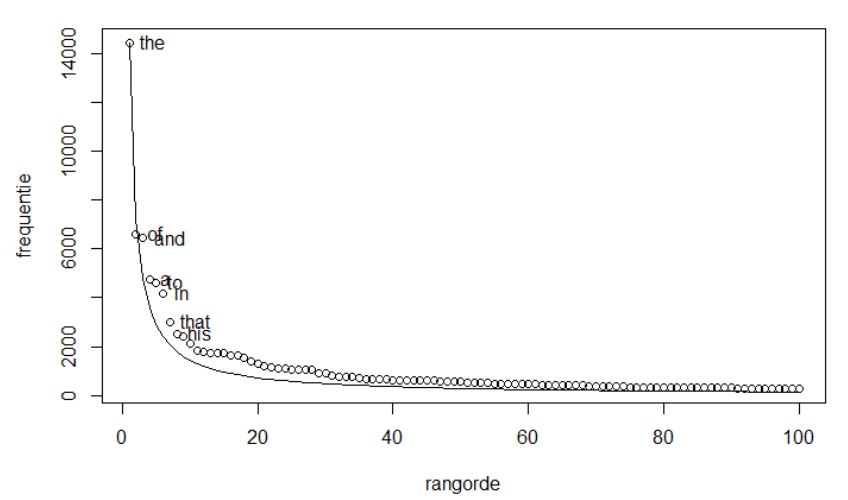

In [ ]:
# Ver vocabulario y labels


Finalmente, preparamos el corpus para entrenar la red neuronal. 

In [ ]:
import torch

#######

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

######

# Construir el modelo

El siguiente paso es construir el model que entrenaremos y evaluaremos. 

Para cada batch, TEXT es un tensor de dimensiones **[text length, batch size]**

El input batch luego pasa por la *embedding layer*, lo que nos da un tensor de dimensiones **[text length, batch size, embedding dim]**. *Embedded* pasa entonces por el RNN. 

El RNN devuelve dos tensores, *output* de dimensiones **[sentence length, batch size, hidden dim]** y *hidden* de dimensiones **[1, batch size, hidden dim]**. *Output* es la concatenación de los hidden steps a cada tiempo *t* y *hidden* es simplemente el *hidden state* final. 

Finalmente, passamos el último *hidden state* a través de una linear layer. 

In [ ]:
# Construir modelo


In [ ]:
# Parámetros


# Entrenar

Vamos a entrenar el modelo. Tendremos que escoger un *optimizer* y una *loss function*. 

In [ ]:
# optimizer


# loss function


In [ ]:
# Modelo y loss function en GPU

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# función para calcular accuracy 

def binary_accuracy(preds, y):
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

La función *train* itera sobre todos los ejemplos, batch por batch. Por cada batch, inicializamos los gradientes a 0. Luego pasamos *batch.text* al modelo. Necesitamos la función *squeeze* porque las predicciones tienen dimensión [batch size, 1] y tenemos que eliminar la dimensión 1, ya que PyTorch espera las predicciones de dimensión [batch size].

La *loss* y *accuracy* se calculan con las predicciones y *labels*, con la loss siendo el promedio por batch.

Calculamos el gradiente de cada parámetro con *loss.backward()* y luego actualizamos los parámetros utilizando los gradientes y optimizer con *optimizer.step()*

Finalmente, devolvemos la *loss* y *accuracy* medias por batch. 

In [ ]:
# Definir train function


La función para evaluar el modelo es muy similar a *train*, pero en modo "evaluación" y sin gradientes, *loss.backward()* ni *optimizer*, ya que no actualizamos los paraámetros del model cuando evaluamos. 

In [ ]:
# Definir evaluate function


In [ ]:
# Función para saber el tiempo que se tarda para entrenar cada epoch

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Entrenamos el modelo con múltiples *epochs*, cada *epoch* es un paso completo de todos los ejemplos del corpus. En cada *epoch*, si la validation loss es la mejor que hemos visto hasta el momento, guardaremos los parámetros del modelo para luego utilizarlo en el test set. 

In [ ]:
# Entrenamos

######

for epoch in range(N_EPOCHS):
  start_time = time.time()

  ######

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  ######

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Test

Finalmente, los resultados que nos importan son los del test set. 

In [ ]:
# Resultados en el test set

########

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')